# Deep Learning Content Based Filtering

Building Menu Recommendation System with Content Based Filtering with Deep Learning by TensorFlow. This notebook provide preprocessing data, training model, post processing and testing the model output to recommending menu based on user input in self assessment content.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
os.listdir('/kaggle/input/')

2024-06-20 09:51:59.863002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 09:51:59.863093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 09:51:59.972408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['user-in-df', 'menu-df']

**Notebook Preparation**

We will use numpy and pandas library to preprocessing purpose (colect, read, and cleaning data), then we also use sickit-learn library for preprocess and postprocess the data too before train the model. Then we use tensorflow to build model, training the model, and save the model.

The path below is tamplate path from kaggle notebook. In Kaggle Notebook, you can upload you dataset, and use it directly to your project

In [2]:
menu_df = pd.read_csv("../input/menu-df/menu.csv")
menu_df

,recipe_name,calories,sugar_content(g),diet_labels,ingredients,servings,image_url
0,Pineapple Angel Food Cake,514.492561,95.821388,"Low-Fat, Low-Sodium","1 20 ounce can of crushed pineapple, 1 Box of ...",12.0,https://edamam-product-images.s3.amazonaws.com...
1,Ginger Berry Compote with Angel Food Cake,1332.868157,76.482700,Low-Fat,"1 bag (1 pound) frozen mixed berries, unthawed...",8.0,https://edamam-product-images.s3.amazonaws.com...
2,Raspberry Fool with Toasted Angel Food Cake,1677.131024,98.829187,NaN,"2½ cups raspberries (about 12 oz.), 2 Tbsp. pl...",6.0,https://edamam-product-images.s3.amazonaws.com...
3,Raspberry Fool with Toasted Angel Food Cake,1677.131024,98.829187,NaN,"4 cups 1"" pieces angel food cake (from about 1...",6.0,https://edamam-product-images.s3.amazonaws.com...
4,Angel Food Cake,1450.164667,203.111750,Low-Fat,"1 cup (130 g) cake flour (not self-rising), 1 ...",6.0,https://edamam-product-images.s3.amazonaws.com...
...,...,...,...,...,...,...,...
4062,Sambal Potatoes With Aioli,2638.871060,29.699772,NaN,"1 whole garlic head, plus 3 garlic cloves, div...",6.0,https://edamam-product-images.s3.amazonaws.com...
4063,Spicy Kecap Manis Fried Rice,1272.990825,4.518095,Balanced,"1 large serrano or jalapeño pepper, stem trimm...",2.0,https://edamam-product-images.s3.amazonaws.com...
4064,Spicy Soy-Sauced Tomatoes,145.640700,15.740867,Low-Fat,"2 medium tomatoes, cut in half and sliced (abo...",2.0,https://edamam-product-images.s3.amazonaws.com...
4065,Garlicky Balinese Grilled Chicken with Lime,3545.302774,31.221667,"High-Fiber, Low-Carb","10 garlic cloves, halved, 3 fresh long red chi...",4.0,https://edamam-product-images.s3.amazonaws.com...


**Cleaning Dataset**

The next thing that we do is to check and cleaning the dataset (checking null input, or duplicate input in dataset), for best training model purpose (avoid overfitting or underfitting)

To check missing value in data, we can use 
> menu_df.isna().sum()

Then, tips if there is missing value in your data, to simplify the process cleaning and for optimize model training process we can overwrite the missing value with the dominan trend of the data. This is example function if we want to overwrite the missing value
> menu_df.fillna(value="input_data", inplace=True)

In [3]:
menu_df.isna().sum()

recipe_name           0
calories              0
sugar_content(g)      0
diet_labels         714
ingredients           0
servings              0
image_url             0
dtype: int64

In [4]:
menu_df[menu_df.diet_labels.isna()]

,recipe_name,calories,sugar_content(g),diet_labels,ingredients,servings,image_url
2,Raspberry Fool with Toasted Angel Food Cake,1677.131024,98.829187,NaN,"2½ cups raspberries (about 12 oz.), 2 Tbsp. pl...",6.0,https://edamam-product-images.s3.amazonaws.com...
3,Raspberry Fool with Toasted Angel Food Cake,1677.131024,98.829187,NaN,"4 cups 1"" pieces angel food cake (from about 1...",6.0,https://edamam-product-images.s3.amazonaws.com...
6,Secret-Ingredient Devil's Food Cupcakes,6196.132000,398.718400,NaN,"3 large eggs, 1 cup mayonnaise, 1 box devil's ...",20.0,https://edamam-product-images.s3.amazonaws.com...
19,Triple Orange Angel Food Cake,2475.975478,341.758262,NaN,1 (15-ounce) can mandarin oranges in light syr...,12.0,https://edamam-product-images.s3.amazonaws.com...
21,Strawberry Angel Food Cake,2720.038000,335.843100,NaN,"1 store-bought angel food cake mix, 1 quart co...",6.0,https://edamam-product-images.s3.amazonaws.com...
...,...,...,...,...,...,...,...
4042,Indonesian Stir-Fried Noodles (Bakmi Goreng),1919.332585,8.402326,NaN,"3 tablespoons peanut oil, divided, 2 large egg...",4.0,https://edamam-product-images.s3.amazonaws.com...
4044,Surf and Turf Braai,5372.163747,208.229212,NaN,200 milliliters (7 ounces) sweet soy sauce (In...,6.0,https://edamam-product-images.s3.amazonaws.com...
4047,Buddha's Delight (Lo Hon Jai): Chinese Vegetar...,1880.919641,12.343538,NaN,1/4 cup reserved shiitake mushroom water (see ...,4.0,https://edamam-product-images.s3.amazonaws.com...
4055,Sambal Tempeh with Lemon Basil,889.815591,22.694600,NaN,"2 tbsp. sunflower oil, plus more for deep fryi...",4.0,https://edamam-product-images.s3.amazonaws.com...


In [5]:
menu_df.diet_labels.value_counts()

diet_labels
Low-Carb                                         880
Low-Sodium                                       322
High-Fiber                                       296
Low-Fat, Low-Sodium                              286
Balanced                                         260
Low-Fat                                          221
Balanced, High-Fiber                             203
Low-Carb, Low-Sodium                             197
High-Fiber, Low-Carb                             124
High-Protein, Low-Carb                           114
High-Fiber, Low-Fat                               97
Balanced, Low-Sodium                              83
High-Fiber, Low-Sodium                            73
High-Fiber, Low-Fat, Low-Sodium                   66
Balanced, High-Fiber, Low-Sodium                  27
High-Protein, Low-Carb, Low-Sodium                26
High-Protein, Low-Fat                             18
High-Protein, Low-Fat, Low-Carb                   17
High-Protein                      

In [6]:
menu_df.fillna(value="Low-Crab", inplace=True)

In [7]:
menu_df.isna().sum()

recipe_name         0
calories            0
sugar_content(g)    0
diet_labels         0
ingredients         0
servings            0
image_url           0
dtype: int64

In [8]:
menu_df.diet_labels.value_counts()

diet_labels
Low-Carb                                         880
Low-Crab                                         714
Low-Sodium                                       322
High-Fiber                                       296
Low-Fat, Low-Sodium                              286
Balanced                                         260
Low-Fat                                          221
Balanced, High-Fiber                             203
Low-Carb, Low-Sodium                             197
High-Fiber, Low-Carb                             124
High-Protein, Low-Carb                           114
High-Fiber, Low-Fat                               97
Balanced, Low-Sodium                              83
High-Fiber, Low-Sodium                            73
High-Fiber, Low-Fat, Low-Sodium                   66
Balanced, High-Fiber, Low-Sodium                  27
High-Protein, Low-Carb, Low-Sodium                26
High-Protein, Low-Fat                             18
High-Protein, Low-Fat, Low-Carb   

In [9]:
user_df = pd.read_csv("../input/user-in-df/user.csv")
user_df

,user_id,age,height (cm),weight (kg),diabetes_history,diabetes_heritage,preferred_food,diet_labels,sugar_intake (g/day),calorie_intake (kcal/day)
0,1,25,175,70,No,No,Pizza,Balanced,50,2500
1,2,34,160,65,Yes,Yes,Salad,Vegan,25,2000
2,3,29,180,80,No,No,Sushi,Low-Carb,50,2200
3,4,42,170,75,Yes,Yes,Pasta,High-Protein,25,2300
4,5,55,165,85,Yes,No,Burger,Low-Fat,25,1800
...,...,...,...,...,...,...,...,...,...,...
3495,3496,32,168,74,No,No,Tofu Stir-Fry,Vegan,50,2200
3496,3497,48,180,85,Yes,Yes,Oatmeal,Immunity,25,2400
3497,3498,36,172,76,No,No,Lentil Soup,Vegan,50,2100
3498,3499,42,178,82,No,No,Baked Chicken,High-Protein,30,2500


In [10]:
# Replicate user data to match the length of menu data
user_df = pd.concat([user_df] * int(np.ceil(len(menu_df) / len(user_df))), ignore_index=True)
user_df = user_df.iloc[:len(menu_df)]  # Trim to match the length of menu_df

**Preparation Data for Training**

First we will get the variable that we want to match and train from menu and user. Then we encode the input variable ,with OneHotEncoder, to be float format, and scaling the encoded variable with StandardScaler. Next the input and target data will be splited to train and test data to training process.

In [11]:
# Extract categorical features
menu_cat_features = menu_df[['diet_labels', 'recipe_name']]
user_cat_features = user_df[['diet_labels', 'preferred_food']]

In [12]:
# Fit the OneHotEncoder separately for menu and user features
menu_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
menu_cat_encoded = menu_ohe.fit_transform(menu_cat_features)

user_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
user_cat_encoded = user_ohe.fit_transform(user_cat_features)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# Convert to float32
menu_features_encoded = np.hstack([menu_cat_encoded]).astype(np.float32)
user_features_encoded = np.hstack([user_cat_encoded]).astype(np.float32)

In [14]:
# Scale the features separately for menu and user features
menu_scaler = StandardScaler()
menu_features_encoded = menu_scaler.fit_transform(menu_features_encoded)

user_scaler = StandardScaler()
user_features_encoded = user_scaler.fit_transform(user_features_encoded)

In [15]:
# Split the data
X_menu_train, X_menu_test, X_user_train, X_user_test = train_test_split(
    menu_features_encoded, user_features_encoded, test_size=0.2, random_state=32)

In [16]:
# Generate random labels for training and testing
y = np.random.randint(0, 2, len(X_menu_train) + len(X_menu_test)).astype(np.float32)
y_train = y[:len(X_menu_train)]
y_test = y[len(X_menu_train):]

In [17]:
print(f"item training data shape: {X_menu_train.shape}")
print(f"item test data shape: {X_menu_test.shape}")

item training data shape: (3253, 3857)
item test data shape: (814, 3857)


**Training Model**

Training model will use tensorflow with custom model. From tensorflow library we use model, early stopping(callback), Dense, Dropout, regulizer, and Adam optimizer for optimizing the training model.

We will use menu and user as diferent input in the neural network which have independent layer. Then each input will be merged with concatenate process to match each input, so we can get the compatibility of each input that play important role in this recommendation system. Then we can start train the model with model.compile, and model.fit.

In model we use Dropout, BatchNormalitation, and kernel_regularizer to avoid overfitting. Than we use optimizer Adam to get the maksimum accuracy, because adam can iterating close range loss fucntion.

We also use earlystoping to build automation stop for the stopping in the best epoch training condition.

In [18]:
# Build the model
input_menu = Input(shape=(menu_features_encoded.shape[1],), name='menu_input')
input_user = Input(shape=(user_features_encoded.shape[1],), name='user_input')

# Menu branch
menu_layer = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(input_menu)
menu_layer = Dropout(0.8)(menu_layer)
menu_layer = BatchNormalization()(menu_layer)

# User branch
user_layer = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(input_user)
user_layer = Dropout(0.8)(user_layer)
user_layer = BatchNormalization()(user_layer)

# Concatenate the outputs of the two branches
concatenated = Concatenate()([menu_layer, user_layer])

# Add more layers
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=[input_menu, input_user], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
history = model.fit([X_menu_train, X_user_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
64/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5102 - loss: 1.2186

I0000 00:00:1718877183.629866     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718877183.647880     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5086 - loss: 1.2051

W0000 00:00:1718877191.537470     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.5085 - loss: 1.2045 - val_accuracy: 0.5100 - val_loss: 0.9973
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5266 - loss: 1.0501 - val_accuracy: 0.4977 - val_loss: 0.9424
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4983 - loss: 0.9812 - val_accuracy: 0.5023 - val_loss: 0.9065
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4933 - loss: 0.9323 - val_accuracy: 0.5008 - val_loss: 0.8817
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5111 - loss: 0.9025 - val_accuracy: 0.4977 - val_loss: 0.8646
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5041 - loss: 0.8846 - val_accuracy: 0.4962 - val_loss: 0.8585
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4950 - loss: 0.8652 - val_accuracy: 0.4962 - val_loss: 0.8390
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4889 - loss: 0.8603 - val_accuracy: 0.4962 - val_loss: 

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate([X_menu_test, X_user_test], y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4906 - loss: 0.9043
Test Loss: 0.9036184549331665
Test Accuracy: 0.5012285113334656


In [20]:
# Example of making predictions
predictions = model.predict([X_menu_test, X_user_test])

 1/26 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step

W0000 00:00:1718827774.396433     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


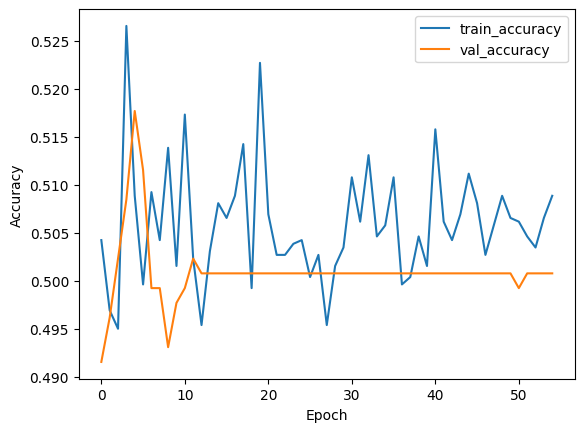

In [21]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

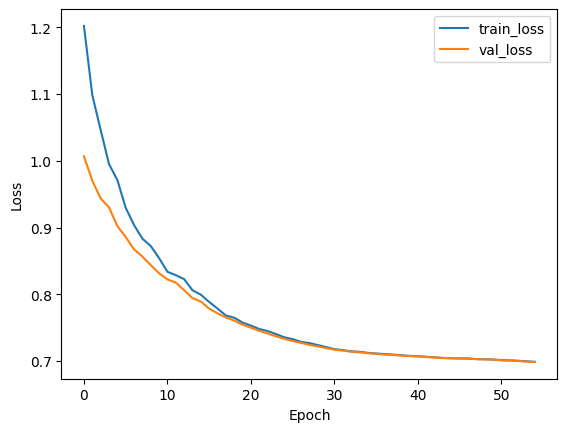

In [22]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Testing Model**

The code below is model testing that we use to generate the recommendation menu from new user input.

In this process, we will repeat the preprocessing step for new input variabel from user (encode the input with OneHotEncoding, then scaling the encode input with StandardScaler

In [23]:
# Example new user input
new_user_input = {
    'diet_labels': 'Balanced',
    'preferred_food': 'Tortilla Soup'
}

new_user_cat_features = pd.DataFrame([{
    'diet_labels': new_user_input['diet_labels'],
    'preferred_food': new_user_input['preferred_food']
}])

new_user_cat_encoded = user_ohe.transform(new_user_cat_features)
new_user_features_encoded = np.hstack([new_user_cat_encoded]).astype(np.float32)

# Scale the new user input features
new_user_features_scaled = user_scaler.transform(new_user_features_encoded)

# Repeat new user input features to match the length of menu features
new_user_features_tiled = np.tile(new_user_features_scaled, (len(menu_features_encoded), 1))

In [24]:
predict_output = model.predict([menu_features_encoded, new_user_features_tiled])

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1718827783.998961     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
menu_df['compatibility_score'] = predict_output

**Generate Recommendation**

From the new input and the post processing above, we will generate the recommendation model to outputing the best compatibility score of the menu and user input from the model variabel

In [26]:
# Sort and get top recommendations
top_n = 10
top_recommendations = menu_df.sort_values(by='compatibility_score', ascending=False).head(top_n)

print("Top Recommendations:")
print(top_recommendations[['recipe_name', 'diet_labels', 'compatibility_score']])

Top Recommendations:
                              recipe_name                         diet_labels  \
1061                Almond Meal Pie Crust                          Low-Sodium   
632            Poppy-seed crusted Chicken  High-Protein, Low-Carb, Low-Sodium   
1219                Simple Chicken Dinner                 High-Fiber, Low-Fat   
3468  Hoisin-Sesame Salad with Baked Tofu                High-Fiber, Low-Carb   
2370                        Basic cookies                          Low-Sodium   
2766               mozzarella pasta salad                            Low-Carb   
1905                  Bing's Beef Rendang                            Low-Carb   
2803            Green Bean and Plum Salad                             Low-Fat   
946           Bacon-Wrapped Ginger Shrimp                            Low-Carb   
2275                  Dragon Tongue Beans                            Low-Carb   

      compatibility_score  
1061             0.525563  
632              0.524283  
121

In [33]:
# Save the model if needed
model.save('Deep_content_based_model.keras')

In [28]:
import pickle

#Save the encoders and scalers
with open('menu_ohe.pkl', 'wb') as f:
    pickle.dump(menu_ohe, f)
with open('user_ohe.pkl', 'wb') as f:
    pickle.dump(user_ohe, f)
with open('menu_scaler.pkl', 'wb') as f:
    pickle.dump(menu_scaler, f)
with open('user_scaler.pkl', 'wb') as f:
    pickle.dump(user_scaler, f)